In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read in CSV
train_pd = pd.read_csv('train_filtered.csv')
test_pd = pd.read_csv('test_filtered.csv')

# Convert string representation of list to actual list of floats
train_pd['features'] = train_pd['features'].apply(lambda x: [float(i) for i in x.strip('[]').split(',')])
test_pd['features'] = test_pd['features'].apply(lambda x: [float(i) for i in x.strip('[]').split(',')])

x_train = torch.from_numpy(np.array(train_pd['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(train_pd['outcome'].values.tolist(), np.int64))

x_test = torch.from_numpy(np.array(test_pd['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(test_pd['outcome'].values.tolist(), np.int64))

# Make sure the data is zero-indexed
y_train = y_train - 2
y_test = y_test - 2
print(y_train.unique())

tensor([0, 1, 2, 3])


In [2]:
print(x_train.shape, y_train.shape)

torch.Size([58630, 113]) torch.Size([58630])


In [3]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

In [4]:
class myNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.ln1 = nn.Linear(input_size, 128)
        self.ln2 = nn.Linear(128, 64)
        self.ln3 = nn.Linear(64, 32)
        self.ln4 = nn.Linear(32, 4)
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.relu(self.ln3(x))
        x = self.ln4(x)
        x = F.softmax(x, dim=-1)
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
def training_loop(n_epochs, model, lr, batch_size):
    model = model.to(device)

    batch_size = batch_size
    num_epochs = n_epochs
    lr = lr
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fcn = nn.CrossEntropyLoss()

    train_loss = []
    test_loss = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        # Initialize variables to store the total loss for this epoch
        total_train_loss = 0
        total_test_loss = 0
        correct_predictions = 0
        total_predictions = 0
        # Training loop
        for batch_id, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)  # Move the data to the device that is used
            opt.zero_grad()  # Zero the gradients
            output = model(x)  # Forward pass
            loss = loss_fcn(output, y)  # Compute the loss

            total_train_loss += loss.item()  # Accumulate the loss
            _, predicted = torch.max(output.data, 1)  # Get the predicted classes
            total_predictions += y.size(0)
            correct_predictions += (predicted == y).sum().item()
            loss.backward()  # Backward pass
            opt.step()  # Update the parameters

        # Store the average training loss for this epoch
        train_loss.append(total_train_loss / len(train_loader))
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1} - Train Accuracy: {correct_predictions / total_predictions}")
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():  # No need to compute gradients during validation
            for batch_id, (x, y) in enumerate(test_loader):
                x, y = x.to(device), y.to(device)  # Move the data to the device that is used
                output = model(x)  # Forward pass
                loss = loss_fcn(output, y )  # Compute the loss
                total_test_loss += loss.item()  # Accumulate the loss
                _, predicted = torch.max(output.data, 1)
                total_predictions += y.size(0)
                correct_predictions += (predicted == y).sum().item()

        # Store the average validation loss for this epoch
        test_loss.append(total_test_loss / len(test_loader))

        # Print the losses every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")
            print(f"Epoch {epoch + 1} - Test Accuracy: {correct_predictions / total_predictions}")

        # Save the best model so far
        if epoch == 0 or test_loss[-1] < np.min(test_loss[:-1]):
            best_model = model
            best_epoch = epoch

        # Early stopping
        if epoch - best_epoch >= 30:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Plot the training and validation losses
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Losses")
    plt.show()

    return best_model

Epoch 5 - Train Accuracy: 0.9948149411564046
Epoch 5 - Train Loss: 0.7488351649967934, Test Loss: 0.9538211975947465
Epoch 5 - Test Accuracy: 0.7889036078859191
Epoch 10 - Train Accuracy: 0.9952242879072147
Epoch 10 - Train Loss: 0.7484329384396539, Test Loss: 0.9597147903820076
Epoch 10 - Test Accuracy: 0.7829034520377153


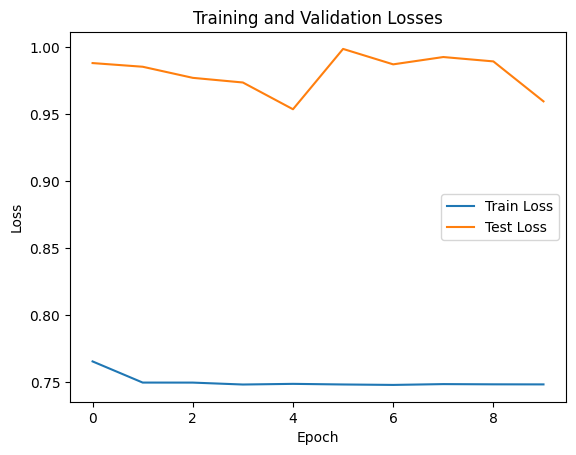

In [7]:
input_size = x_train.shape[1]
models = myNeuralNet(input_size)
best_model = training_loop(10, models, 0.004, 128)

In [9]:
# Deeper MLP
class myDeeperNeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.ln1 = nn.Linear(input_size, 128)
        self.ln2 = nn.Linear(128, 64)
        self.ln3 = nn.Linear(64, 64)
        self.ln4 = nn.Linear(64, 64)
        self.ln5 = nn.Linear(64, 32)
        self.ln6 = nn.Linear(32, 16)
        self.ln7 = nn.Linear(16, 8)
        self.ln8 = nn.Linear(8, 4)
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.relu(self.ln3(x))
        x = F.relu(self.ln4(x))
        x = F.relu(self.ln5(x))
        x = F.relu(self.ln6(x))
        x = F.relu(self.ln7(x))
        x = self.ln8(x)
        x = F.softmax(x, dim =-1)
        return x

Epoch 5 - Train Accuracy: 0.9811871055773494
Epoch 5 - Train Loss: 0.7615674234646237, Test Loss: 1.0369091929487921
Epoch 5 - Test Accuracy: 0.6996025870801839
Epoch 10 - Train Accuracy: 0.9910284837114105
Epoch 10 - Train Loss: 0.7565224632433836, Test Loss: 0.9952197828103061
Epoch 10 - Test Accuracy: 0.7728512428894257
Epoch 15 - Train Accuracy: 0.9983796691113764
Epoch 15 - Train Loss: 0.7453158856803969, Test Loss: 0.9613736156207412
Epoch 15 - Test Accuracy: 0.7765915997818125
Epoch 20 - Train Accuracy: 0.9984137813406107
Epoch 20 - Train Loss: 0.7452715871051824, Test Loss: 0.9561181823116037
Epoch 20 - Test Accuracy: 0.7841502376685109
Epoch 25 - Train Accuracy: 0.9985843424867815
Epoch 25 - Train Loss: 0.7450951536171305, Test Loss: 0.9465093158963901
Epoch 25 - Test Accuracy: 0.7950596119379724
Epoch 30 - Train Accuracy: 0.9986525669452498
Epoch 30 - Train Loss: 0.745022019986175, Test Loss: 0.9566838787266271
Epoch 30 - Test Accuracy: 0.7856307956050806
Epoch 35 - Train Acc

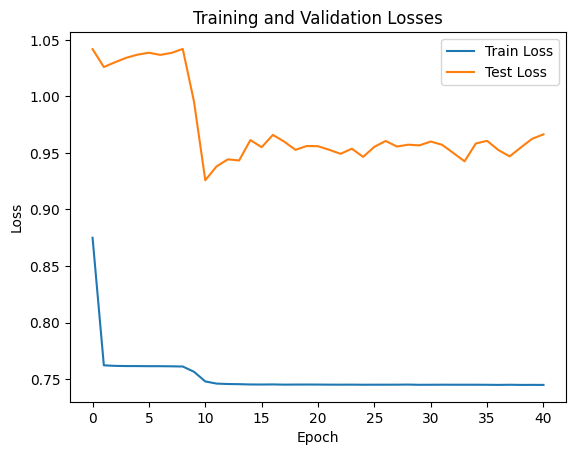

In [12]:
input_size = x_train.shape[1]
models = myDeeperNeuralNet(input_size)
deep_model = training_loop(100, models, 0.0001, 32)

Epoch 5 - Train Accuracy: 0.9984649496844619
Epoch 5 - Train Loss: 0.006879448452008573, Test Loss: 1.4087253879032917
Epoch 5 - Test Accuracy: 0.8228005922231746
Epoch 10 - Train Accuracy: 0.9990448575814429
Epoch 10 - Train Loss: 0.0037667805434895315, Test Loss: 1.9847079859444159
Epoch 10 - Test Accuracy: 0.7945920673264241
Epoch 15 - Train Accuracy: 0.9993859798737847
Epoch 15 - Train Loss: 0.002609053397684376, Test Loss: 1.9931910979510539
Epoch 15 - Test Accuracy: 0.7945141432244993
Epoch 20 - Train Accuracy: 0.9995565410199556
Epoch 20 - Train Loss: 0.0019483271906391676, Test Loss: 2.262985096048953
Epoch 20 - Test Accuracy: 0.7946699914283488
Epoch 25 - Train Accuracy: 0.999624765478424
Epoch 25 - Train Loss: 0.0015351538044523824, Test Loss: 2.0950286397293434
Epoch 25 - Test Accuracy: 0.7898386971090158
Epoch 30 - Train Accuracy: 0.9995735971345727
Epoch 30 - Train Loss: 0.001545183861689854, Test Loss: 2.012756508084672
Epoch 30 - Test Accuracy: 0.7970077144860905
Early s

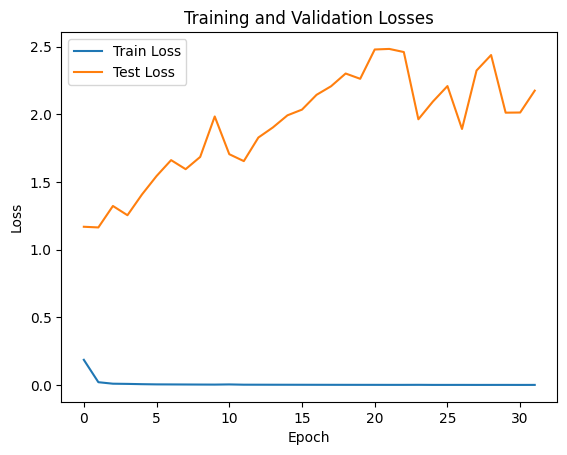

In [13]:
# Try CNN
class DeepCNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * (input_dim // 16), 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
input_size = x_train.shape[1]    
models = DeepCNN(input_size)
cnn_model = training_loop(50, models, 0.00004, 64)


In [14]:
from collections import Counter

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def max_voting(*args):
    # Transpose to get a list of predictions for each example
    predictions = torch.stack(args).permute(1, 0, 2)
    # Apply max voting
    final_predictions = torch.tensor([Counter(predictions[i].argmax(dim=1).tolist()).most_common(1)[0][0] for i in range(predictions.shape[0])])
    return final_predictions

ground_truths = []
predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        # Assuming each model outputs logits for each class
        inputs = inputs.to(device)  # Move inputs to the correct device
        labels = labels.to(device)  # Move labels to the correct device if they're used later
        outputs1 = best_model(inputs)
        outputs2 = deep_model(inputs)
        outputs3 = cnn_model(inputs)
        
        # Get predictions
        voted_predictions  = max_voting(outputs1, outputs2, outputs3)
        predictions.extend(voted_predictions.cpu().tolist())
        ground_truths.extend(labels.cpu().numpy())

# Convert all_predictions to a tensor if needed
import numpy as np
predictions = np.array(predictions)
ground_truths = np.array(ground_truths)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(ground_truths, predictions)
precision = precision_score(ground_truths, predictions, average='macro')  # 'macro' averages across classes
recall = recall_score(ground_truths, predictions, average='macro')
f1 = f1_score(ground_truths, predictions, average='macro')
conf_matrix = confusion_matrix(ground_truths, predictions)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.805657289799735
Precision: 0.6508515328047788
Recall: 0.5907965663021454
F1 Score: 0.5970151605419602
Confusion Matrix:
 [[7030  239    0  189]
 [ 432 1972    1   16]
 [ 812  611 1311   20]
 [  84   55   35   26]]
